## Что делаем ##

Сервис быстрой доставки SkySamokat.

Периодически клиентам рассылаются пуш-уведомления, в которых описывается специальное предложение недели.
Имеем список клиентов, которые получали эти пуш-уведомления. По результату рассылки они воспользовались или не воспользовались предложением (поле ***flag_conv***).

Нужно проверить, не будет ли смс-сообщение более эффективным чем пуш-уведомление. Необходимо протестировать систему сплитования и рассчитать время, необходимое для расчета эксперимента.

In [1]:
### Импортируем необходимое

import pandas as pd
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import datetime as dt
import random
import math

df = pd.read_csv('Данные Бизнес-4.csv', sep=',')
df.head()

,id_client,flag_conv
0,1345321,0
1,1345322,0
2,1345330,0
3,1345338,1
4,1345342,0


In [2]:
### Проверяем данные

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id_client  3169 non-null   int64
 1   flag_conv  3169 non-null   int64
dtypes: int64(2)
memory usage: 49.6 KB


In [3]:

df.duplicated().sum()

### df.drop_duplicates(inplace = True) (если необходимо удалить дубликаты и перезаписать датафрейм без дубликатов)

np.int64(0)

In [4]:

df.isnull().sum()

### df.dropna(inplace = True) (если необходимо удалить нулы и перезаписать датафрейм без дубликатов). По "умолчанию" удалять нулы можно, если удаляется не более 5% данных.

id_client    0
flag_conv    0
dtype: int64

### Решение ###

In [5]:
### 1. Исследуем зависимость пользования предложением от идентификатора клиента.

df['right_symbol'] = df['id_client'].astype(str).str[-1]
df.head()

,id_client,flag_conv,right_symbol
0,1345321,0,1
1,1345322,0,2
2,1345330,0,0
3,1345338,1,8
4,1345342,0,2


In [6]:

df_agg = df.groupby('right_symbol').agg(conv = ('flag_conv', 'mean')).reset_index()
df_agg.head(10)

,right_symbol,conv
0,0,0.996835
1,1,0.603715
2,2,0.543689
3,3,0.543624
4,4,0.528662
5,5,0.545732
6,6,0.529412
7,7,0.632258
8,8,0.563518
9,9,0.632716


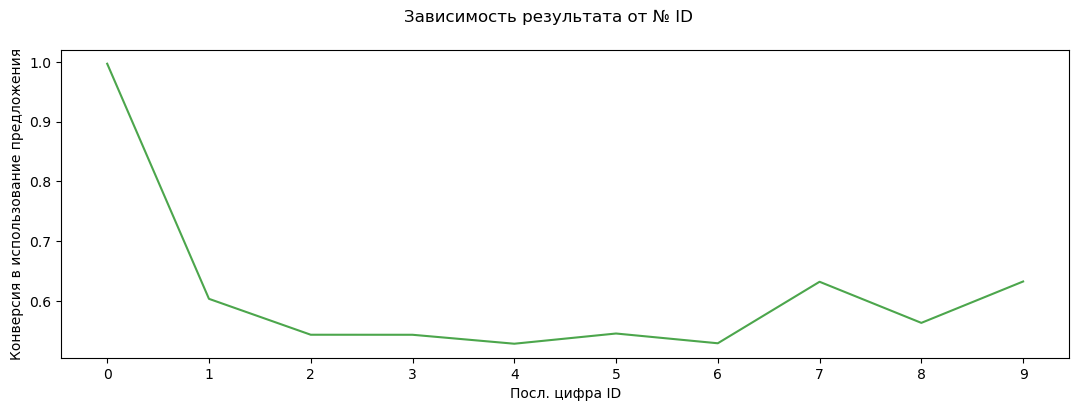

In [7]:

plt.rcParams["figure.figsize"] = (13,4)
fig, ax = plt.subplots()
fig.suptitle('Зависимость результата от № ID')

ax.plot(df_agg['right_symbol'], df_agg['conv'], color = 'green', alpha=.7)
ax.set_xlabel('Посл. цифра ID')
ax.set_ylabel('Конверсия в использование предложения')
plt.show()

на вскидку - можем предположить, что распределение выборки было неверным, на что указывает почти в два раза более высокая конверсия по ID, заказчивающимся на 0

In [8]:
### 2. Делаем разбиение клиентов по группам (контроль и тест) в зависимости от остатка деления ID на 10. Расчитываем АА-тест.

df['to_10'] = df['id_client'] % 10
unique_values = df['to_10'].unique()

while True:
    try:
        selected_values = tuple(np.random.choice(unique_values, size = 5, replace = False))
        df['group_10'] = np.where(df['to_10'].isin(selected_values), 'test', 'control')
        r1 = df[df['group_10'] == 'control']['flag_conv']
        r2 = df[df['group_10'] == 'test']['flag_conv']
        alpha = 0.05
        s, p = mannwhitneyu(r1, r2)
        if p > alpha:
            break
        else:
            print('Распределения не равны, сетап(разбиение) для эксперимента выбран некорректно')
            print(f'Значения колонки to_10 для тестовой группы = {selected_values}')
            print()
    except:
        print('Нет данных')
print(f'Распределения равны. P_value = {p}')
print(f'Значения колонки to_10 для тестовой группы = {selected_values}')
print()

Распределения не равны, сетап(разбиение) для эксперимента выбран некорректно
Значения колонки to_10 для тестовой группы = (np.int64(7), np.int64(9), np.int64(8), np.int64(4), np.int64(6))

Распределения не равны, сетап(разбиение) для эксперимента выбран некорректно
Значения колонки to_10 для тестовой группы = (np.int64(9), np.int64(0), np.int64(4), np.int64(8), np.int64(6))

Распределения не равны, сетап(разбиение) для эксперимента выбран некорректно
Значения колонки to_10 для тестовой группы = (np.int64(2), np.int64(7), np.int64(5), np.int64(3), np.int64(9))

Распределения не равны, сетап(разбиение) для эксперимента выбран некорректно
Значения колонки to_10 для тестовой группы = (np.int64(7), np.int64(5), np.int64(6), np.int64(9), np.int64(1))

Распределения не равны, сетап(разбиение) для эксперимента выбран некорректно
Значения колонки to_10 для тестовой группы = (np.int64(1), np.int64(5), np.int64(7), np.int64(3), np.int64(8))

Распределения не равны, сетап(разбиение) для эксперимен

In [9]:

df_info = df.groupby('group_10').agg(cnt_client = ('id_client', 'count'), conv = ('flag_conv', 'mean')).reset_index()
df_info.head()

,group_10,cnt_client,conv
0,control,1573,0.595677
1,test,1596,0.627820


In [10]:

s1, p1 = ttest_ind(r1, r2)
print(s1)
alpha = 0.05
if p1 >= alpha:
    print(f'p value = {p1}. Принимаем H0 -> нет стат. значимой разницы между выборками.')
else:
    print(f'p value = {p1}. Принимаем H1 -> есть стат. значимая разница между выборками.')
print()

-1.856860558249869
p value = 0.06342378196333834. Принимаем H0 -> нет стат. значимой разницы между выборками.



In [11]:
### 3. Распределяем клиентов по группам (контроль и тест) на основе остатка от деления ID на 2. Расчитываем результаты АА-теста.

df['to_2'] = df['id_client'] % 2
df['group_2'] = np.where(df['to_2'] == 0, 'test', 'control')
df.head()

,id_client,flag_conv,right_symbol,to_10,group_10,to_2,group_2
0,1345321,0,1,1,control,1,control
1,1345322,0,2,2,control,0,test
2,1345330,0,0,0,test,0,test
3,1345338,1,8,8,control,0,test
4,1345342,0,2,2,control,0,test


In [12]:

df_info1 = df.groupby('group_2').agg(cnt_client = ('id_client', 'count'), conv = ('flag_conv', 'mean')).reset_index()
df_info1.head()

,group_2,cnt_client,conv
0,control,1583,0.591914
1,test,1586,0.631778


In [13]:

alpha = 0.05
ss, pp = mannwhitneyu(df[df['group_2'] == 'control']['flag_conv'], df[df['group_2'] == 'test']['flag_conv'])
if pp > alpha:
    print('Распределения равны')
    print('P_value = ',pp)
    print()
else:
    print('Распределения не равны')

Распределения не равны


In [14]:

ss1, pp1 = ttest_ind(df[df['group_2'] == 'control']['flag_conv'], df[df['group_2'] == 'test']['flag_conv'])
print(ss1)
alpha = 0.05
if pp1 >= alpha:
    print(f'p value = {pp1}. Принимаем H0 -> нет стат. значимой разницы между выборками.')
else:
    print(f'p value = {pp1}. Принимаем H1 -> есть стат. значимая разница между выборками.')
print()

-2.303661902563631
p value = 0.021306090686166332. Принимаем H1 -> есть стат. значимая разница между выборками.



In [15]:
### 4. Распределяем клиентов по группам (контроль и тест) с помощью функции sample (1000 разбиений) из библиотеки pandas и считаем статистическую значимость разниц.

results = []

for i in range(1,1000):
    part_50 = df.sample(frac = 0.5)
    rest_part_50 = df.drop(part_50.index)

    s_a, p_a = ttest_ind(part_50['flag_conv'], rest_part_50['flag_conv'])

    results.append({'iter':i,'stat_crit':s_a,'p_value':p_a})
    df_aa = pd.DataFrame(results)

df_aa.head()

,iter,stat_crit,p_value
0,1,-0.597223,0.550401
1,2,-0.087025,0.930657
2,3,-0.815917,0.414609
3,4,-1.180495,0.237892
4,5,-0.670118,0.502832


In [16]:

df_aa[df_aa['p_value']<=0.05].count() / df_aa.count()

iter         0.047047
stat_crit    0.047047
p_value      0.047047
dtype: float64

In [17]:

m = df_aa['p_value'].mean()
sig = df_aa['p_value'].std()

print('Среднее = ', m)
print('Сигма = ', sig)

Среднее =  0.5087249063347672
Сигма =  0.2908079169180479


In [18]:

df_two_sigma = df_aa[(df_aa['p_value'] >= m - 2*sig) & (df_aa['p_value'] <= m + 2*sig)]
print('Доля случаев, в которых разница между группами есть - ', 1 - (df_two_sigma.count()['iter'] / df_aa.count()['iter']))

Доля случаев, в которых разница между группами есть -  0.0


In [19]:
### 5. Cколько наблюдений потребуется для АБ Теста (MDE = 2 проц.п, альфа и бета на дефолтном уровне и дисперсия выборки не изменится от воздействия В).

m = df['flag_conv'].mean()
sigma = m*(1-m)
n = 16 * sigma / (0.02**2)

print(f'Требуемое кол-во наблюдений в самой маленькой группе = {n}')
print(f'Общее требуемое кол-во наблюдений в двух группах = {n * 2}')

Требуемое кол-во наблюдений в самой маленькой группе = 9499.449393436595
Общее требуемое кол-во наблюдений в двух группах = 18998.89878687319
